In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, Subset

In [ ]:
import os
import shutil

In [ ]:
train_dir = "/content/gdrive/MyDrive/APS360/pix2pix/pix2pix_np_splitdataset/train"
val_dir = "/content/gdrive/MyDrive/APS360/pix2pix/pix2pix_np_splitdataset/val"
combined_dir = "/content/gdrive/MyDrive/APS360/pix2pix /combined data"

os.makedirs(combined_dir, exist_ok=True)

for source_dir in [train_dir, val_dir]:
    for filename in os.listdir(source_dir):
        if not filename.lower().endswith((".jpg", ".png", ".npz")):
            continue

        src_path = os.path.join(source_dir, filename)
        dst_path = os.path.join(combined_dir, filename)


        if os.path.exists(dst_path):
            base, ext = os.path.splitext(filename)
            counter = 1
            new_filename = f"{base}_{counter}{ext}"
            new_dst_path = os.path.join(combined_dir, new_filename)
            while os.path.exists(new_dst_path):
                counter += 1
                new_filename = f"{base}_{counter}{ext}"
                new_dst_path = os.path.join(combined_dir, new_filename)
            dst_path = new_dst_path

        shutil.copy(src_path, dst_path)

In [ ]:
from PIL import Image
import numpy as np

In [ ]:
def preprocess_images(input_dir, output_dir, resize_to=(256, 256)):
  os.makedirs(output_dir, exist_ok=True)

  for filename in os.listdir(input_dir):

    path = os.path.join(input_dir, filename)
    img = Image.open(path).convert("RGB")

    if img.size != (1200, 600):
            print(f"Skipping {filename}: expected 1200x600, got {img.size}")
            continue


    satellite = img.crop((0,0,600,600))
    map = img.crop((600,0,1200,600))

    satellite = satellite.resize(resize_to, Image.BICUBIC) #if anyone is wondering the BICUBIC is for smoother and higher quality images
    map = map.resize(resize_to, Image.BICUBIC)

    paired_img = Image.new("RGB", (resize_to[0]*2, resize_to[1]))
    paired_img.paste(satellite, (0, 0))
    paired_img.paste(map, (resize_to[0], 0))

    save_path = os.path.join(output_dir, filename)
    paired_img.save(save_path)
    print("saved pair images", save_path)


preprocess_images("/content/gdrive/MyDrive/Colab Notebooks/APS360/pix2pix /combined data","/content/gdrive/MyDrive/Colab Notebooks/APS360/pix2pix /paired images resized")

saved pair images /content/gdrive/MyDrive/Colab Notebooks/APS360/pix2pix /paired images resized/3_1.jpg
saved pair images /content/gdrive/MyDrive/Colab Notebooks/APS360/pix2pix /paired images resized/1.jpg


In [ ]:
import os
import numpy as np
from PIL import Image


input_dir = "/content/gdrive/MyDrive/APS360/pix2pix /paired images resized"


output_dir = "/content/gdrive/MyDrive/APS360/pix2pix /pix2pix_np"
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):

    img_path = os.path.join(input_dir, filename)
    img = Image.open(img_path).convert("RGB")


    if img.size != (512, 256):
        print(f"Skipping {filename} due to unexpected size: {img.size}")
        continue


    w, h = img.size
    input_img = img.crop((0, 0, w//2, h))    # Satellite
    target_img = img.crop((w//2, 0, w, h))   # Map


    input_np_satellite = np.asarray(input_img).astype(np.float32) / 255.0
    target_np_map = np.asarray(target_img).astype(np.float32) / 255.0

    input_np_satellite = (input_np_satellite - 0.5) / 0.5 #p.s. I normalized it to the standard pix2pix as [-1,1] we will still need to normalize during training after kernels
    target_np_map = (target_np_map - 0.5) / 0.5



    input_np_satellite = np.transpose(input_np_satellite, (2, 0, 1))
    target_np_map = np.transpose(target_np_map, (2, 0, 1)) #it's now in channel height width format

    save_name = filename.replace(".jpg", ".npz").replace(".jpeg", ".npz")
    save_path = os.path.join(output_dir, save_name)
    np.savez_compressed(save_path, input=input_np_satellite, target=target_np_map)
    print(f"Saved: {save_path}")

Saved: /content/gdrive/MyDrive/APS360/pix2pix /pix2pix_np/227_1.npz
Saved: /content/gdrive/MyDrive/APS360/pix2pix /pix2pix_np/258_1.npz
Saved: /content/gdrive/MyDrive/APS360/pix2pix /pix2pix_np/168_1.npz
Saved: /content/gdrive/MyDrive/APS360/pix2pix /pix2pix_np/229_1.npz
Saved: /content/gdrive/MyDrive/APS360/pix2pix /pix2pix_np/17_1.npz
Saved: /content/gdrive/MyDrive/APS360/pix2pix /pix2pix_np/223_1.npz
Saved: /content/gdrive/MyDrive/APS360/pix2pix /pix2pix_np/234_1.npz
Saved: /content/gdrive/MyDrive/APS360/pix2pix /pix2pix_np/179_1.npz
Saved: /content/gdrive/MyDrive/APS360/pix2pix /pix2pix_np/170_1.npz
Saved: /content/gdrive/MyDrive/APS360/pix2pix /pix2pix_np/219_1.npz
Saved: /content/gdrive/MyDrive/APS360/pix2pix /pix2pix_np/22_1.npz
Saved: /content/gdrive/MyDrive/APS360/pix2pix /pix2pix_np/218_1.npz
Saved: /content/gdrive/MyDrive/APS360/pix2pix /pix2pix_np/154_1.npz
Saved: /content/gdrive/MyDrive/APS360/pix2pix /pix2pix_np/2_1.npz
Saved: /content/gdrive/MyDrive/APS360/pix2pix /pix2p

In [ ]:
#Data Splitting
#80% Training, 10% Validation , 10% Testing
input_dir = "/content/gdrive/MyDrive/APS360/pix2pix /pix2pix_np"
output_dir = "/content/gdrive/MyDrive/APS360/pix2pix/pix2pix_np_splitdataset"

train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")

for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

torch.manual_seed(1000)
np.random.seed(1000)

dataset = np.array(sorted(os.listdir(input_dir)))

np.random.shuffle(dataset)
print(f'Total images: {len(dataset)}')
train_data = dataset[:int(0.8 * len(dataset))]
val_data = dataset[int(0.8 * len(dataset)):int(0.9 * len(dataset))]
test_data = dataset[int(0.9 * len(dataset)):]

print(f'Training images: {len(train_data)}')
print(f'Validation images: {len(val_data)}')
print(f'Test images: {len(test_data)}')

def copy_files(data, folder):
        for file in data:
            src_path = os.path.join(input_dir, file)
            dst_path = os.path.join(folder, file)
            shutil.copy(src_path, dst_path)

copy_files(train_data, train_dir)
copy_files(val_data, val_dir)
copy_files(test_data, test_dir)

Total images: 2194
Training images: 1755
Validation images: 219
Test images: 220


In [ ]:
#Data Augmentation
#Horizontal flip, rotation , Crop
train_dir = "/content/gdrive/MyDrive/APS360/pix2pix/pix2pix_np_splitdataset/train"
import torchvision.transforms.functional as F
import random # Import the random module


class Augmentation:
    def __call__(self,sat,maps):

        if torch.rand(1) < 0.5:
            sat= F.hflip(sat)
            maps = F.hflip(maps)

        rotation_angle = [0,90,180]
        if rotation_angle:
           angle = random.choice(rotation_angle)
        if angle != 0:
            sat = F.rotate(sat, angle)
            maps = F.rotate(maps, angle)

        sat = F.resize(sat, 286)
        maps = F.resize(maps, 286)

        i, j, h, w = transforms.RandomCrop.get_params(sat, output_size=(256, 256))
        sat = F.crop(sat, i, j, h, w)
        maps = F.crop(maps, i, j, h, w)

        return sat,maps

In [ ]:
class Pix2PixDataset(Dataset):
    def __init__(self, root_dir, augment= True):
      self.augment = augment
      self.root_dir = root_dir
      self.image_files = os.listdir(root_dir)
      print(f"Found {len(self.image_files)} files in {root_dir}") # Added print
      self.data = []
      for filename in self.image_files:
          npz_path = os.path.join(self.root_dir, filename)
          try: # Added try-except block
              with np.load(npz_path) as data:
                  self.data.append((data['input'], data['target']))
          except Exception as e: # Added exception handling
              print(f"Error loading {npz_path}: {e}") # Added print for errors
      print(f"Loaded {len(self.data)} data samples.") # Added print


    def __len__(self):
      return len(self.data) # Changed from self.image_files to self.data

    def __getitem__(self, idx):
        input_img, target_img = self.data[idx]
        #normalized te image
        input_img = torch.from_numpy(input_img).float()
        target_img = torch.from_numpy(target_img).float()

        if self.augment:
            augment = Augmentation()
            input_img, target_img = augment(input_img, target_img)

        return input_img, target_img



In [ ]:
train_dataset = Pix2PixDataset("/content/gdrive/MyDrive/Colab Notebooks/APS360/pix2pix/pix2pix_np_splitdataset/train", augment=True)
val_dataset = Pix2PixDataset("/content/gdrive/MyDrive/Colab Notebooks/APS360/pix2pix/pix2pix_np_splitdataset/val", augment=False )
test_dataset = Pix2PixDataset("/content/gdrive/MyDrive/Colab Notebooks/APS360/pix2pix/pix2pix_np_splitdataset/test", augment=False)

train_loader = DataLoader(train_dataset, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=64)

Found 1755 files in /content/gdrive/MyDrive/Colab Notebooks/APS360/pix2pix/pix2pix_np_splitdataset/train
Loaded 1755 data samples.
Found 219 files in /content/gdrive/MyDrive/Colab Notebooks/APS360/pix2pix/pix2pix_np_splitdataset/val
Loaded 219 data samples.
Found 220 files in /content/gdrive/MyDrive/Colab Notebooks/APS360/pix2pix/pix2pix_np_splitdataset/test
Loaded 220 data samples.


Input shape: (3, 256, 256) Min: -1.0 Max: 1.0
Target shape: (3, 256, 256) Min: 0.26274514 Max: 1.0


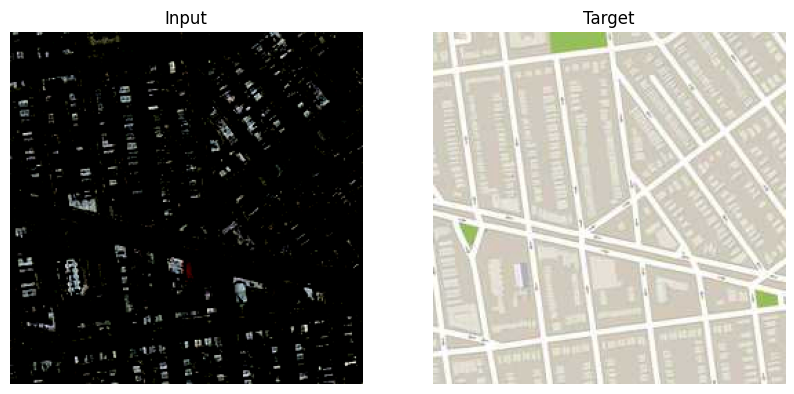

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


npz_path = "/content/gdrive/MyDrive/Colab Notebooks/APS360/pix2pix/pix2pix_np_splitdataset/train/1.npz"


data = np.load(npz_path)
input_img = data['input']
target_img = data['target']


print("Input shape:", input_img.shape, "Min:", input_img.min(), "Max:", input_img.max())
print("Target shape:", target_img.shape, "Min:", target_img.min(), "Max:", target_img.max())


if input_img.shape[0] == 3:
    input_img = np.transpose(input_img, (1, 2, 0))
if target_img.shape[0] == 3:
    target_img = np.transpose(target_img, (1, 2, 0))

if input_img.max() > 1:
    input_img = input_img / 255.0
if target_img.max() > 1:
    target_img = target_img / 255.0


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.clip(input_img, 0, 1))
axs[0].set_title("Input")
axs[0].axis('off')
axs[1].imshow(np.clip(target_img, 0, 1))
axs[1].set_title("Target")
axs[1].axis('off')
plt.show()


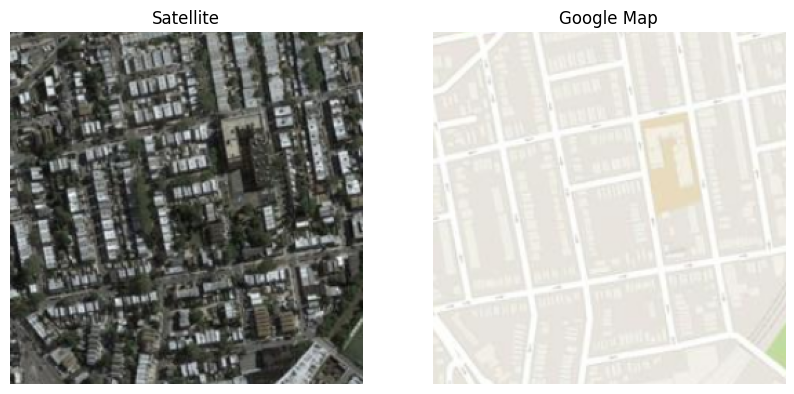

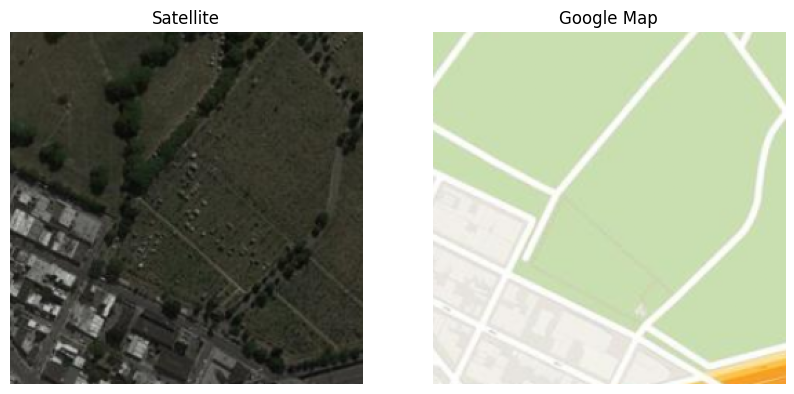

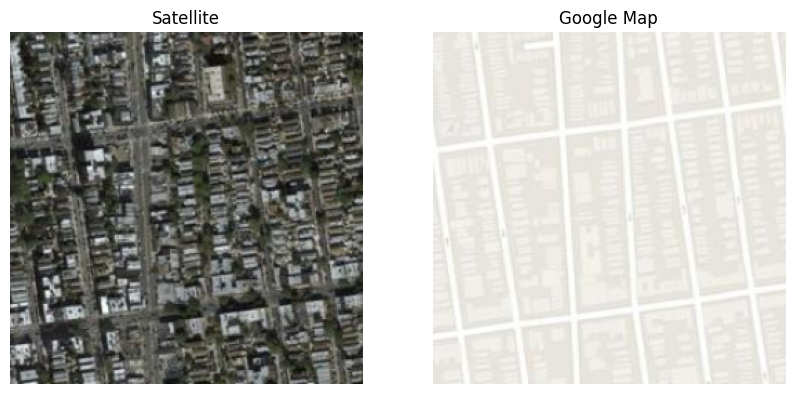

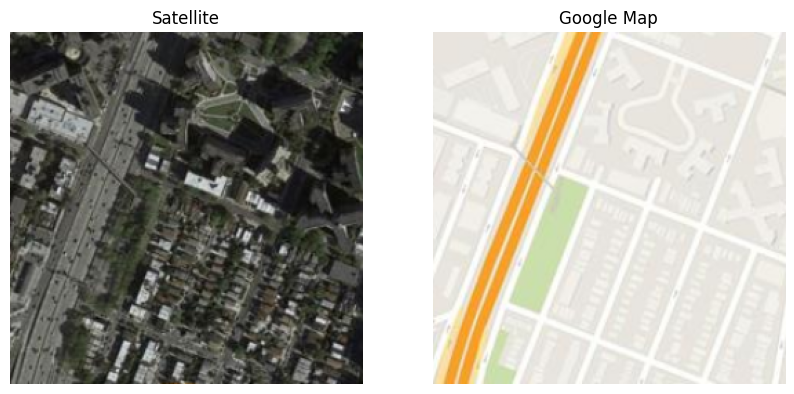

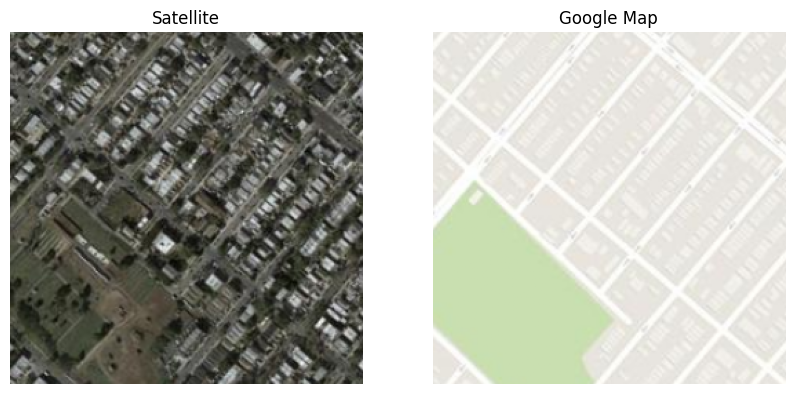

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    img = (img + 1) / 2
    img = np.clip(img, 0, 1)
    return img


k= 0
for input_img, target_img in train_dataset:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(imshow(input_img))
    plt.axis('off')
    plt.title("Satellite")

    plt.subplot(1, 2, 2)
    plt.imshow(imshow(target_img))
    plt.axis('off')
    plt.title("Google Map")
    k+=1
    if k==5:
        break

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torch


def denorm(t):
    return torch.clamp((t + 1.0) / 2.0, 0.0, 1.0)


def show_batch(data_loader, num_images=5):
    data_iter = iter(data_loader)
    sat_batch, map_batch = next(data_iter)

    aug = Augmentation()
    plt.figure(figsize=(14, 6))

    for i in range(num_images):
        sat_img = denorm(sat_batch[i])
        map_img = torch.clamp(map_batch[i], 0.0, 1.0)

        # Augmented version
        sat_aug, map_aug = aug(sat_img.clone(), map_img.clone())

        # Original Satellite
        plt.subplot(3, num_images, i + 1)
        plt.imshow(sat_img.permute(1, 2, 0).cpu())
        plt.title("Satellite")
        plt.axis("off")

        # Original Map
        plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(map_img.permute(1, 2, 0).cpu())
        plt.title("Map")
        plt.axis("off")

        # Augmented Satellite & Map side by side
        plt.subplot(3, num_images, 2 * num_images + i + 1)
        combined = torch.cat([sat_aug, map_aug], dim=2)  # concat along width
        plt.imshow(combined.permute(1, 2, 0).cpu())
        plt.title("Augmented Pair")
        plt.axis("off")

    plt.tight_layout()
    plt.show()




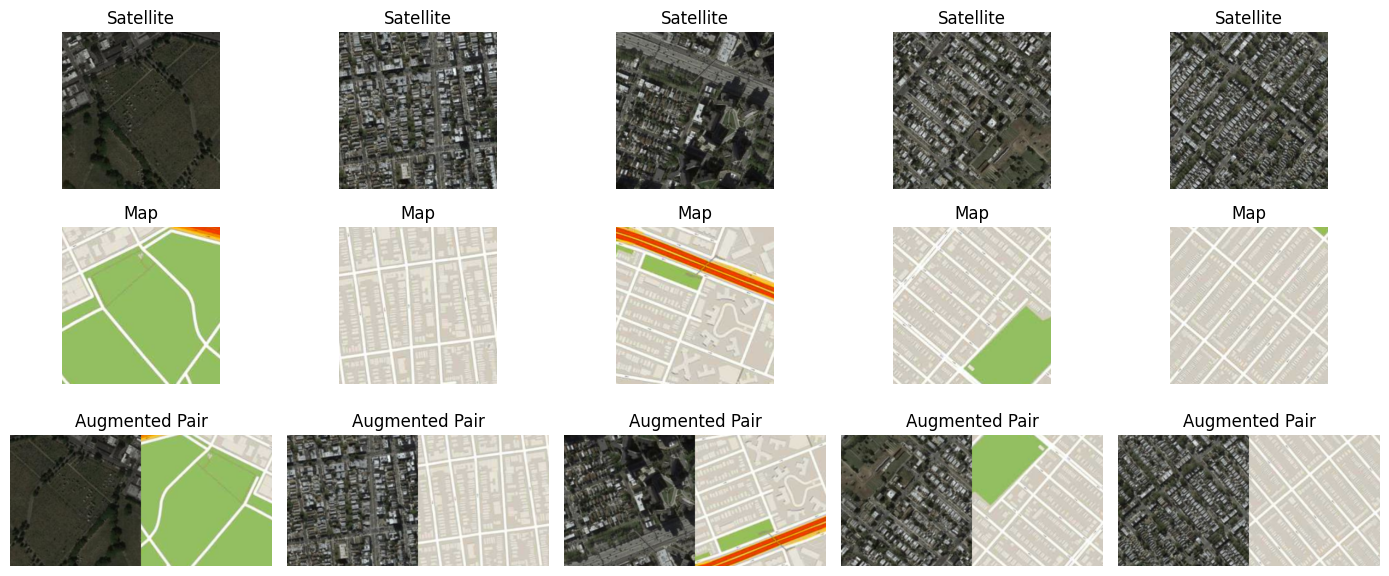

In [ ]:
train_dir ="/content/gdrive/MyDrive/Colab Notebooks/APS360/pix2pix/pix2pix_np_splitdataset/train"

# train_dataset_plain = Pix2PixDataset(train_dir, augment=False) #this code is to compare the original to the augmented code
# plain_loader = DataLoader(train_dataset_plain, batch_size=64, shuffle=False)


show_batch(train_loader, num_images=5)



Baseline Model: Colab Link : https://colab.research.google.com/drive/16saPU4NMrtZSs4h2KWhXGMgeTkOxH5oB?usp=sharing

Primary Model:

In [ ]:
#I will begin the code for generator from here
class EncoderBlock(nn.Module):
  def __init__(self, Input_Channels, Output_Channels, Batchnorm = False):
    super(EncoderBlock, self).__init__()
    self.batchnorm = Batchnorm
    self.conv = nn.Conv2d(Input_Channels, Output_Channels, 4,2, 1)

    if self.batchnorm:
      self.bn = nn.BatchNorm2d(Output_Channels)


    self.Leakyrelu = nn.LeakyReLU(0.2, inplace = True) #look I chose Leaky Relu as the activation as it is most commonly used, however when tuning hyper paramters this is one of the things you can experiment on

  def forward(self, x):
    x = self.conv(x)
    if self.batchnorm:
      x = self.bn(x)
    x = self.Leakyrelu(x)
    return x




In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, Input_Channels, Output_Channels, Dropout = True):
    super(DecoderBlock, self).__init__()
    self.conv_trans= nn.ConvTranspose2d(Input_Channels, Output_Channels, 4, 2, 1, bias=False)
    self.norm = nn.InstanceNorm2d(Output_Channels)
    self.relu = nn.ReLU(inplace=True) #again for the upscaling portion Relu is commonly used


    self.use_dropout = Dropout
    if self.use_dropout:
      self.dropout = nn.Dropout(0.5)

  def forward(self, x, skip_input):
    x = self.conv_trans(x)
    x = self.norm(x)
    if self.use_dropout:
      x = self.dropout(x)
    x = self.relu(x)
    x = torch.cat((x, skip_input), 1)
    return x




In [ ]:
class Generator(nn.Module):
  def __init__(self, in_channels=3, out_channels=3):
    super(Generator,self).__init__()

    self.dn1 = EncoderBlock(in_channels, 64, Batchnorm = False)
    self.dn2 = EncoderBlock(64, 128)
    self.dn3 = EncoderBlock(128, 256)
    self.dn4 = EncoderBlock(256,512)
    self.dn5 = EncoderBlock(512,512)
    self.dn6 = EncoderBlock(512,512)
    self.dn7 = EncoderBlock(512,512)
    self.dn8 = EncoderBlock(512,512)

    self.up1 = DecoderBlock(512, 512)
    self.up2 = DecoderBlock(1024, 512)
    self.up3 = DecoderBlock(1024, 512)
    self.up4 = DecoderBlock(1024, 512, Dropout=False)
    self.up5 = DecoderBlock(1024, 256, Dropout=False)
    self.up6 = DecoderBlock(512, 128, Dropout=False)
    self.up7 = DecoderBlock(256, 64, Dropout=False)

    self.final = nn.Sequential(
        nn.Upsample(scale_factor = 2),
        nn.ZeroPad2d((1,0,1,0)),
        nn.Conv2d(128, out_channels, 4, padding=1), #number of output channels
        nn.Tanh() #final activation changes in all I guess we can tune this as well idk?

    )

  def forward(self, x):
    d1 = self.dn1(x)
    d2 = self.dn2(d1)
    d3 = self.dn3(d2)
    d4 = self.dn4(d3)
    d5 = self.dn5(d4)
    d6 = self.dn6(d5)
    d7 = self.dn7(d6)
    d8 = self.dn8(d7)
    u1 = self.up1(d8, d7)
    u2 = self.up2(u1, d6)
    u3 = self. up3 (u2, d5)
    u4 = self. up4(u3, d4)
    u5 = self. up5(u4, d3)
    u6 = self. up6(u5, d2)
    u7 = self.up7(u6, d1)
    u8 = self. final(u7)
    return u8






In [ ]:
#Discriminator Code starts here

class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm = True):
        super(DiscriminatorBlock,self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=not BatchNorm)
        self.batchnorm = BatchNorm
        if self.batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.Leakyrelu = nn.LeakyReLU(0.2, inplace = True) #I chose Leaky Relu as this was given in the original paper to use with 0.2 slope

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        return self.Leakyrelu(x)




class Discriminator(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(Discriminator, self).__init__()
        # input will be concatenation of source and target: channels = in_channels * 2
        #The 70 × 70 discriminator architecture is: C64-C128-C256-C512
        self.block1 = DiscriminatorBlock(in_channels * 2, 64, BatchNorm=False)  # C64, no BatchNorm
        self.block2 = DiscriminatorBlock(64, 128)   # C128
        self.block3 = DiscriminatorBlock(128, 256)  # C256
        self.block4 = DiscriminatorBlock(256, 512)  # C512
        self.conv5 = nn.Conv2d(512, 512, kernel_size=4, stride=1, padding=1, bias=False)
        self.bn5   = nn.BatchNorm2d(512)
        self.Leakyrelu = nn.LeakyReLU(0.2, inplace=True)

        self.conv_out = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        self.sigmoid  = nn.Sigmoid()
        self.apply(self._init_weights)
        #All networks were trained from scratch. Weights wereinitialized from a Gaussian distribution with mean 0 andstandard deviation 0.02.

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0.0)




    def forward(self, src, target):
        # concatenate source and target images channel-wise
        x = torch.cat([src, target], dim=1)

        x = self.block1(x)  # C64
        x = self.block2(x)  # C128
        x = self.block3(x)  # C256
        x = self.block4(x)  # C512
        # conv stride=1
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.Leakyrelu(x)

        # final patch output
        x = self.conv_out(x)
        return self.sigmoid(x)

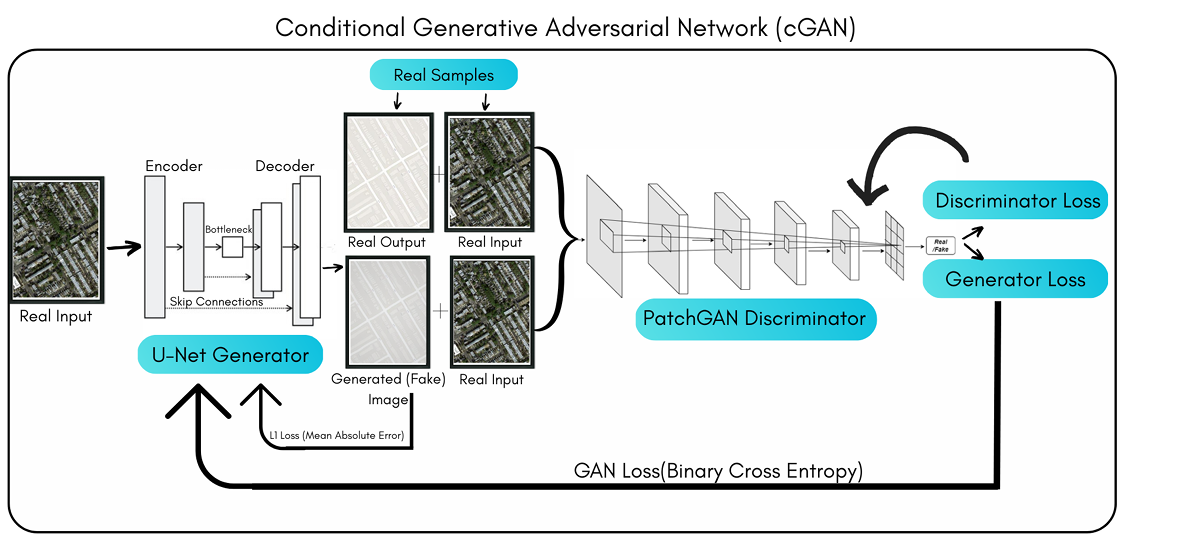

In [ ]:
#Hyperparameter Tuning Section:
#Training:
def train_discrimintor(discriminator, generator, input_images, real_target_images, criterion, optimizer_discr):
    batch_size = input_images.size(0)
    optimizer_discr.zero_grad()
    #passing real image and getting loss
    real_output = discriminator(input_images, real_target_images)
    real_labels = torch.ones_like(real_output)
    real_loss = criterion(real_output, real_labels) #i assumed here that loss comparison is BCE in discriminator
    #passing generated images and getting loss
    fake_target_images = generator(input_images).detach()  # Detach to prevent gradient flow to generator
    fake_output = discriminator(input_images, fake_target_images)
    fake_labels = torch.zeros_like(fake_output)
    fake_loss = criterion(fake_output, fake_labels) #same i assumed BCE loss here again

    discr_loss = real_loss + fake_loss /2
    discr_loss.backward()
    optimizer_discr.step()
    return discr_loss, real_output, fake_output

In [ ]:
def train_generator(discriminator, generator,input_images,target,optimizer_generator, L1_lambda,criterion_GAN,criterion_l1):
   #we know that generator has two losses GAN loss(BCE loss& gradient) & L1 loss (mean absolute error)
    batch_size = input_images.size(0)

    optimizer_generator.zero_grad()
    generated_image = generator(input_images)
    discr_output = discriminator(input_images, generated_image)
    real_labels = torch.ones_like(discr_output) # this will allow the generator to fooool(make fake real-like) the discriminator
    # generator_loss = criterion_GAN(discr_output, real_labels)  + L1_lambda * torch.abs(generated_image-target).sum() #(Salma btw) when I first ran your training the g_loss was x10000 like this was the value 67144720.0000 and these values and the discriminator was plateuing therefore I change the code slightly reducing the L1 loss
    #Epoch [29/50], D_loss: 0.6599, G_loss: 32727734.0000 this was what the old generator loss was doing
    #with the code below it should stablise
    #generator_loss = criterion_GAN(discr_output, real_labels) + L1_lambda * torch.mean(torch.abs(generated_image - target))
    generator_loss = criterion_GAN(discr_output, real_labels) + L1_lambda * criterion_l1(generated_image, target)
    generator_loss.backward()
    optimizer_generator.step()
    return generated_image, generator_loss

In [ ]:
!pip install tqdm
from tqdm import tqdm

In [ ]:
def train(generator, discriminator, train_loader, num_epochs=50, batch_size=64, lr=0.0002, beta1=0.5, beta2=0.999, lambda_L1=100):
    from tqdm import tqdm
    import time

    criterion_gan = nn.BCEWithLogitsLoss()
    criterion_l1 = nn.L1Loss()
    optimizer_discr = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
    optimizer_generator = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
    #############################################
    #To Enable GPU Usage
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        generator = generator.cuda()
        discriminator = discriminator.cuda()
     #############################################


    iters ,d_losses ,g_losses = [],[],[]

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch + 1}/{num_epochs}]")
        epoch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

        for input_images, real_target_images in epoch_bar: #I made a slight edit to add a time progress bar so I can know how long the epochs are taking

            if use_cuda:
                input_images = input_images.cuda()
                real_target_images = real_target_images.cuda()


            d_loss, real_output, fake_output = train_discrimintor(discriminator, generator, input_images, real_target_images, criterion_gan, optimizer_discr)

            generated_image, g_loss = train_generator(discriminator, generator, input_images, real_target_images,optimizer_generator, lambda_L1, criterion_gan,criterion_l1)
#you didn't include or consider the batch size so I removed it from your original train_generator function
            # save the current training information
            iters.append(n)
            d_losses.append(float(d_loss))
            g_losses.append(float(g_loss))
            n += 1

        if (epoch + 1) % 10 == 0:
          checkpoint_path = f"/content/gdrive/MyDrive/APS360{epoch+1}.pth"

          torch.save({
              'generator': generator.state_dict(),
              'discriminator': discriminator.state_dict(),
              'optimizer_g': optimizer_generator.state_dict(),
              'optimizer_d': optimizer_discr.state_dict(),
              'epoch': epoch + 1,
          }, checkpoint_path)

          print(f" Saved checkpoint to {checkpoint_path}") #I added in this code because it takes so long to train and the runtime disconnects so I wanted to save after every 10 epochs so I don't need to restart always


        print(f"Epoch [{epoch+1}/{num_epochs}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

    # plotting losses
    plt.title("Training Loss Curve")
    plt.plot(iters, d_losses, label="Discriminator Loss")
    plt.plot(iters, g_losses, label="Generator Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()



CUDA is available!  Training on GPU ...

Epoch [1/50]


Epoch [1/50], D_loss: 0.7210, G_loss: 14.1301

Epoch [2/50]


Epoch [2/50], D_loss: 0.7214, G_loss: 12.5183

Epoch [3/50]


Epoch [3/50], D_loss: 0.6896, G_loss: 11.8375

Epoch [4/50]


Epoch [4/50], D_loss: 0.8172, G_loss: 10.3005

Epoch [5/50]


Epoch [5/50], D_loss: 0.7493, G_loss: 10.4840

Epoch [6/50]


Epoch [6/50], D_loss: 0.7286, G_loss: 9.6986

Epoch [7/50]


Epoch [7/50], D_loss: 0.7012, G_loss: 9.9235

Epoch [8/50]


Epoch [8/50], D_loss: 0.6951, G_loss: 7.7316

Epoch [9/50]


Epoch [9/50], D_loss: 0.6606, G_loss: 10.7633

Epoch [10/50]


Epoch [10/50], D_loss: 0.6609, G_loss: 9.5557

Epoch [11/50]


Epoch [11/50], D_loss: 0.6607, G_loss: 7.2666

Epoch [12/50]


Epoch [12/50], D_loss: 0.6604, G_loss: 8.4080

Epoch [13/50]


Epoch [13/50], D_loss: 0.6601, G_loss: 9.4543

Epoch [14/50]


Epoch [14/50], D_loss: 0.9382, G_loss: 8.3747

Epoch [15/50]


Epoch [15/50], D_loss: 1.0370, G_loss: 8.0122

Epoch [16/50]


Epoch [16/50], D_loss: 0.6775, G_loss: 8.5398

Epoch [17/50]


Epoch [17/50], D_loss: 0.6610, G_loss: 7.3498

Epoch [18/50]


Epoch [18/50], D_loss: 0.6613, G_loss: 7.7687

Epoch [19/50]


Epoch [19/50], D_loss: 0.6601, G_loss: 7.7129

Epoch [20/50]


Epoch [20/50], D_loss: 0.6608, G_loss: 9.2975

Epoch [21/50]


Epoch [21/50], D_loss: 0.6601, G_loss: 6.7926

Epoch [22/50]


Epoch [22/50], D_loss: 0.6600, G_loss: 7.7167

Epoch [23/50]


Epoch [23/50], D_loss: 0.6599, G_loss: 8.0717

Epoch [24/50]


Epoch [24/50], D_loss: 0.6599, G_loss: 8.0268

Epoch [25/50]


Epoch [25/50], D_loss: 0.6599, G_loss: 8.1599

Epoch [26/50]


Epoch [26/50], D_loss: 0.6601, G_loss: 6.9833

Epoch [27/50]


Epoch [27/50], D_loss: 0.6599, G_loss: 7.1576

Epoch [28/50]


Epoch [28/50], D_loss: 0.6599, G_loss: 6.5144

Epoch [29/50]


Epoch [29/50], D_loss: 0.6599, G_loss: 8.8473

Epoch [30/50]


Epoch [30/50], D_loss: 0.6599, G_loss: 7.6328

Epoch [31/50]


Epoch [31/50], D_loss: 0.6599, G_loss: 8.2803

Epoch [32/50]


Epoch [32/50], D_loss: 0.6599, G_loss: 7.8043

Epoch [33/50]


Epoch [33/50], D_loss: 0.6599, G_loss: 7.3268

Epoch [34/50]


Epoch [34/50], D_loss: 0.6599, G_loss: 7.7851

Epoch [35/50]


Epoch [35/50], D_loss: 0.6599, G_loss: 7.6951

Epoch [36/50]


Epoch [36/50], D_loss: 0.6599, G_loss: 6.4656

Epoch [37/50]


Epoch [37/50], D_loss: 0.6603, G_loss: 8.6578

Epoch [38/50]


Epoch [38/50], D_loss: 0.6599, G_loss: 7.0356

Epoch [39/50]


Epoch [39/50], D_loss: 0.6599, G_loss: 7.6558

Epoch [40/50]


Epoch [40/50], D_loss: 0.6599, G_loss: 7.2789

Epoch [41/50]


Epoch [41/50], D_loss: 0.6599, G_loss: 6.7652

Epoch [42/50]


Epoch [42/50], D_loss: 0.6599, G_loss: 7.7553

Epoch [43/50]


Epoch [43/50], D_loss: 0.6599, G_loss: 6.9080

Epoch [44/50]


Epoch [44/50], D_loss: 0.6599, G_loss: 8.2760

Epoch [45/50]


Epoch [45/50], D_loss: 0.6599, G_loss: 6.8758

Epoch [46/50]


Epoch [46/50], D_loss: 0.6599, G_loss: 6.3678

Epoch [47/50]


Epoch [47/50], D_loss: 0.6599, G_loss: 7.8047

Epoch [48/50]


Epoch [48/50], D_loss: 0.6599, G_loss: 7.5599

Epoch [49/50]


Epoch [49/50], D_loss: 0.6599, G_loss: 6.6697

Epoch [50/50]


Epoch [50/50], D_loss: 0.6599, G_loss: 7.0709


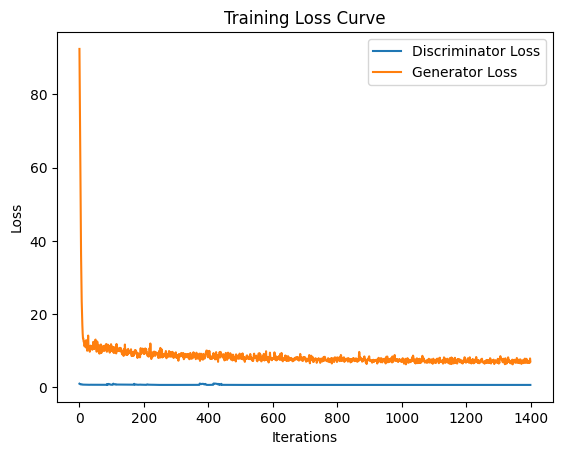

In [ ]:
#1
use_cuda = True
#num_epochs=50, batch_size=64, lr=0.0002, beta1=0.5, beta2=0.999, lambda_L1=100

generator = Generator()
discriminator = Discriminator()

if use_cuda and torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train(generator, discriminator, train_loader, num_epochs=50, batch_size=64, lr=0.0002, beta1=0.5, beta2=0.999, lambda_L1=100)

In [ ]:
#2
use_cuda = True
#lr changed to 0.0004
# num_epochs=50, batch_size=64, lr=0.0004, beta1=0.5, beta2=0.999, lambda_L1=100)

generator = Generator()
discriminator = Discriminator()

if use_cuda and torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train(generator, discriminator, train_loader, num_epochs=50, batch_size=64, lr=0.0004, beta1=0.5, beta2=0.999, lambda_L1=100)

CUDA is available!  Training on GPU ...

Epoch [1/50]


Epoch [1/50], D_loss: 0.6987, G_loss: 9.6115

Epoch [2/50]


Epoch [2/50], D_loss: 0.7046, G_loss: 10.0903

Epoch [3/50]


Epoch [3/50], D_loss: 0.7521, G_loss: 10.0823

Epoch [4/50]


Epoch [4/50], D_loss: 0.6943, G_loss: 9.9363

Epoch [5/50]


Epoch [5/50], D_loss: 0.6845, G_loss: 8.7169

Epoch [6/50]


Epoch [6/50], D_loss: 0.6868, G_loss: 8.4236

Epoch [7/50]


Epoch [7/50], D_loss: 0.6947, G_loss: 8.2030

Epoch [8/50]


Epoch [8/50], D_loss: 1.0049, G_loss: 9.2513

Epoch [9/50]


Epoch [9/50], D_loss: 1.0009, G_loss: 10.3884

Epoch [10/50]


✅ Saved checkpoint to /content/drive/MyDrive/Colab Notebooks/APS36010.pth
Epoch [10/50], D_loss: 0.9199, G_loss: 8.1860

Epoch [11/50]


Epoch [11/50], D_loss: 0.7333, G_loss: 7.8755

Epoch [12/50]


Epoch [12/50], D_loss: 0.6609, G_loss: 7.6688

Epoch [13/50]


Epoch [13/50], D_loss: 0.6602, G_loss: 9.7656

Epoch [14/50]


Epoch [14/50], D_loss: 0.6600, G_loss: 8.5923

Epoch [15/50]


Epoch [15/50], D_loss: 0.6600, G_loss: 8.5220

Epoch [16/50]


Epoch [16/50], D_loss: 0.6599, G_loss: 9.1941

Epoch [17/50]


Epoch [17/50], D_loss: 0.6622, G_loss: 6.8607

Epoch [18/50]


Epoch [18/50], D_loss: 0.6600, G_loss: 7.0852

Epoch [19/50]


Epoch [19/50], D_loss: 0.6599, G_loss: 7.4633

Epoch [20/50]


✅ Saved checkpoint to /content/drive/MyDrive/Colab Notebooks/APS36020.pth
Epoch [20/50], D_loss: 0.6599, G_loss: 10.1287

Epoch [21/50]


Epoch [21/50], D_loss: 0.6599, G_loss: 7.7977

Epoch [22/50]


Epoch [22/50], D_loss: 0.6599, G_loss: 6.7121

Epoch [23/50]


Epoch [23/50], D_loss: 0.6599, G_loss: 8.8620

Epoch [24/50]


Epoch [24/50], D_loss: 0.6599, G_loss: 7.7368

Epoch [25/50]


Epoch [25/50], D_loss: 0.6599, G_loss: 7.6137

Epoch [26/50]


Epoch [26/50], D_loss: 0.6599, G_loss: 8.9758

Epoch [27/50]


Epoch [27/50], D_loss: 0.6599, G_loss: 7.6555

Epoch [28/50]


Epoch [28/50], D_loss: 0.6599, G_loss: 9.0569

Epoch [29/50]


Epoch [29/50], D_loss: 0.6599, G_loss: 8.1944

Epoch [30/50]


✅ Saved checkpoint to /content/drive/MyDrive/Colab Notebooks/APS36030.pth
Epoch [30/50], D_loss: 0.6599, G_loss: 7.3649

Epoch [31/50]


Epoch [31/50], D_loss: 0.6599, G_loss: 6.8163

Epoch [32/50]


Epoch [32/50], D_loss: 0.6599, G_loss: 7.0302

Epoch [33/50]


Epoch [33/50], D_loss: 0.6598, G_loss: 8.1848

Epoch [34/50]


Epoch [34/50], D_loss: 0.6599, G_loss: 6.4916

Epoch [35/50]


Epoch [35/50], D_loss: 0.6599, G_loss: 7.0075

Epoch [36/50]


Epoch [36/50], D_loss: 0.6599, G_loss: 7.7623

Epoch [37/50]


Epoch [37/50], D_loss: 0.6599, G_loss: 6.6862

Epoch [38/50]


Epoch [38/50], D_loss: 0.6598, G_loss: 7.4896

Epoch [39/50]


Epoch [39/50], D_loss: 0.6598, G_loss: 7.9935

Epoch [40/50]


✅ Saved checkpoint to /content/drive/MyDrive/Colab Notebooks/APS36040.pth
Epoch [40/50], D_loss: 0.6598, G_loss: 7.2677

Epoch [41/50]


Epoch [41/50], D_loss: 0.6598, G_loss: 6.5494

Epoch [42/50]


Epoch [42/50], D_loss: 0.6599, G_loss: 6.1673

Epoch [43/50]


Epoch [43/50], D_loss: 0.6599, G_loss: 6.4005

Epoch [44/50]


Epoch [44/50], D_loss: 0.6598, G_loss: 6.9157

Epoch [45/50]


Epoch [45/50], D_loss: 0.6598, G_loss: 7.7916

Epoch [46/50]


Epoch [46/50], D_loss: 0.6598, G_loss: 8.9884

Epoch [47/50]


Epoch [47/50], D_loss: 0.6599, G_loss: 6.0082

Epoch [48/50]


Epoch 48:  29%|██▊       | 8/28 [00:25<01:04,  3.22s/it]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


CUDA is available!  Training on GPU ...

Epoch [1/50]


Epoch [1/50], D_loss: 0.7389, G_loss: 11.2724

Epoch [2/50]


Epoch [2/50], D_loss: 0.8783, G_loss: 10.6489

Epoch [3/50]


Epoch [3/50], D_loss: 0.7292, G_loss: 10.0492

Epoch [4/50]


Epoch [4/50], D_loss: 0.7250, G_loss: 9.5396

Epoch [5/50]


Epoch [5/50], D_loss: 0.7149, G_loss: 9.4185

Epoch [6/50]


Epoch [6/50], D_loss: 0.7298, G_loss: 9.7662

Epoch [7/50]


Epoch [7/50], D_loss: 0.7190, G_loss: 9.4004

Epoch [8/50]


Epoch [8/50], D_loss: 0.6611, G_loss: 10.4409

Epoch [9/50]


Epoch [9/50], D_loss: 0.6608, G_loss: 9.1730

Epoch [10/50]


 Saved checkpoint to /content/gdrive/MyDrive/APS36010.pth
Epoch [10/50], D_loss: 0.6603, G_loss: 9.1126

Epoch [11/50]


Epoch [11/50], D_loss: 0.6601, G_loss: 9.2192

Epoch [12/50]


Epoch [12/50], D_loss: 0.6601, G_loss: 8.7976

Epoch [13/50]


Epoch [13/50], D_loss: 0.6600, G_loss: 9.3639

Epoch [14/50]


Epoch [14/50], D_loss: 0.6601, G_loss: 8.7657

Epoch [15/50]


Epoch [15/50], D_loss: 0.7603, G_loss: 8.8825

Epoch [16/50]


Epoch [16/50], D_loss: 0.6601, G_loss: 8.8771

Epoch [17/50]


Epoch [17/50], D_loss: 0.6599, G_loss: 8.8016

Epoch [18/50]


Epoch [18/50], D_loss: 0.6600, G_loss: 7.8069

Epoch [19/50]


Epoch [19/50], D_loss: 0.6599, G_loss: 8.3219

Epoch [20/50]


 Saved checkpoint to /content/gdrive/MyDrive/APS36020.pth
Epoch [20/50], D_loss: 0.6599, G_loss: 9.3637

Epoch [21/50]


Epoch [21/50], D_loss: 0.6599, G_loss: 7.9256

Epoch [22/50]


Epoch [22/50], D_loss: 0.6603, G_loss: 7.2407

Epoch [23/50]


Epoch [23/50], D_loss: 0.6599, G_loss: 8.5162

Epoch [24/50]


Epoch [24/50], D_loss: 0.6599, G_loss: 7.2989

Epoch [25/50]


Epoch [25/50], D_loss: 0.6599, G_loss: 9.5126

Epoch [26/50]


Epoch [26/50], D_loss: 0.6599, G_loss: 8.7105

Epoch [27/50]


Epoch [27/50], D_loss: 0.6599, G_loss: 7.3766

Epoch [28/50]


Epoch [28/50], D_loss: 0.6600, G_loss: 6.9935

Epoch [29/50]


Epoch [29/50], D_loss: 0.6604, G_loss: 7.1455

Epoch [30/50]


 Saved checkpoint to /content/gdrive/MyDrive/APS36030.pth
Epoch [30/50], D_loss: 0.6599, G_loss: 7.3973

Epoch [31/50]


Epoch [31/50], D_loss: 0.6599, G_loss: 7.8013

Epoch [32/50]


Epoch [32/50], D_loss: 0.6599, G_loss: 6.8479

Epoch [33/50]


Epoch [33/50], D_loss: 0.6599, G_loss: 7.4076

Epoch [34/50]


Epoch [34/50], D_loss: 0.6599, G_loss: 8.9845

Epoch [35/50]


Epoch [35/50], D_loss: 0.6599, G_loss: 6.8009

Epoch [36/50]


Epoch [36/50], D_loss: 0.6599, G_loss: 7.5577

Epoch [37/50]


Epoch [37/50], D_loss: 0.6599, G_loss: 6.9206

Epoch [38/50]


Epoch [38/50], D_loss: 0.6599, G_loss: 6.7582

Epoch [39/50]


Epoch [39/50], D_loss: 0.6599, G_loss: 6.7149

Epoch [40/50]


 Saved checkpoint to /content/gdrive/MyDrive/APS36040.pth
Epoch [40/50], D_loss: 0.6599, G_loss: 6.6674

Epoch [41/50]


Epoch [41/50], D_loss: 0.6599, G_loss: 6.8912

Epoch [42/50]


Epoch [42/50], D_loss: 0.6599, G_loss: 6.7223

Epoch [43/50]


Epoch [43/50], D_loss: 0.6599, G_loss: 6.7110

Epoch [44/50]


Epoch [44/50], D_loss: 0.6599, G_loss: 6.6217

Epoch [45/50]


Epoch [45/50], D_loss: 0.6599, G_loss: 6.6642

Epoch [46/50]


Epoch [46/50], D_loss: 0.6599, G_loss: 6.5244

Epoch [47/50]


Epoch [47/50], D_loss: 0.6599, G_loss: 6.6666

Epoch [48/50]


Epoch [48/50], D_loss: 0.6599, G_loss: 6.5120

Epoch [49/50]


Epoch [49/50], D_loss: 0.6598, G_loss: 7.3599

Epoch [50/50]


 Saved checkpoint to /content/gdrive/MyDrive/APS36050.pth
Epoch [50/50], D_loss: 0.6599, G_loss: 6.6491


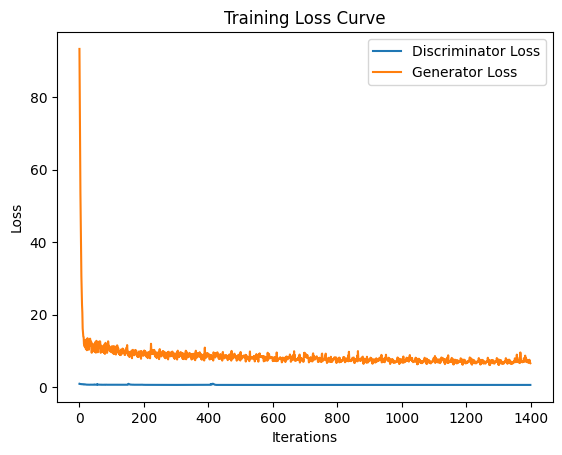

In [ ]:
#3
#batch size changed to 16
# num_epochs=50, batch_size=16, lr=0.0002, beta1=0.5, beta2=0.999, lambda_L1=100)

generator = Generator()
discriminator = Discriminator()

use_cuda = True
if use_cuda and torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
      print('CUDA is not available.  Training on CPU ...')

train(generator, discriminator, train_loader, num_epochs=50, batch_size=16, lr=0.0002, beta1=0.5, beta2=0.999, lambda_L1=100)

CUDA is available!  Training on GPU ...

Epoch [1/50]


Epoch [1/50], D_loss: 0.7092, G_loss: 10.8171

Epoch [2/50]


Epoch [2/50], D_loss: 0.6755, G_loss: 10.2343

Epoch [3/50]


Epoch [3/50], D_loss: 0.6727, G_loss: 9.8571

Epoch [4/50]


Epoch [4/50], D_loss: 0.6733, G_loss: 9.4439

Epoch [5/50]


Epoch [5/50], D_loss: 0.6601, G_loss: 9.7557

Epoch [6/50]


Epoch [6/50], D_loss: 0.6601, G_loss: 9.2409

Epoch [7/50]


Epoch [7/50], D_loss: 0.6600, G_loss: 8.9889

Epoch [8/50]


Epoch [8/50], D_loss: 0.6600, G_loss: 8.8130

Epoch [9/50]


Epoch [9/50], D_loss: 0.6600, G_loss: 8.7685

Epoch [10/50]


 Saved checkpoint to /content/gdrive/MyDrive/APS36010.pth
Epoch [10/50], D_loss: 0.6599, G_loss: 8.5916

Epoch [11/50]


Epoch [11/50], D_loss: 0.6599, G_loss: 8.2443

Epoch [12/50]


Epoch [12/50], D_loss: 0.6599, G_loss: 8.3585

Epoch [13/50]


Epoch [13/50], D_loss: 0.6599, G_loss: 8.3929

Epoch [14/50]


Epoch [14/50], D_loss: 0.6599, G_loss: 8.9290

Epoch [15/50]


Epoch [15/50], D_loss: 0.6599, G_loss: 9.0471

Epoch [16/50]


Epoch [16/50], D_loss: 0.6599, G_loss: 8.9934

Epoch [17/50]


Epoch [17/50], D_loss: 0.6599, G_loss: 9.0259

Epoch [18/50]


Epoch [18/50], D_loss: 0.6599, G_loss: 8.7616

Epoch [19/50]


Epoch [19/50], D_loss: 0.6599, G_loss: 7.9388

Epoch [20/50]


 Saved checkpoint to /content/gdrive/MyDrive/APS36020.pth
Epoch [20/50], D_loss: 0.6599, G_loss: 8.3796

Epoch [21/50]


Epoch [21/50], D_loss: 0.6599, G_loss: 8.9812

Epoch [22/50]


Epoch [22/50], D_loss: 0.6599, G_loss: 7.2731

Epoch [23/50]


Epoch [23/50], D_loss: 0.6599, G_loss: 9.0103

Epoch [24/50]


Epoch [24/50], D_loss: 0.6599, G_loss: 7.0948

Epoch [25/50]


Epoch [25/50], D_loss: 0.6599, G_loss: 7.1409

Epoch [26/50]


Epoch [26/50], D_loss: 0.6599, G_loss: 8.6898

Epoch [27/50]


Epoch [27/50], D_loss: 0.6599, G_loss: 6.9119

Epoch [28/50]


Epoch [28/50], D_loss: 0.6599, G_loss: 6.7915

Epoch [29/50]


Epoch [29/50], D_loss: 0.6599, G_loss: 6.7400

Epoch [30/50]


 Saved checkpoint to /content/gdrive/MyDrive/APS36030.pth
Epoch [30/50], D_loss: 0.6598, G_loss: 8.0654

Epoch [31/50]


Epoch [31/50], D_loss: 0.6599, G_loss: 6.7028

Epoch [32/50]


Epoch [32/50], D_loss: 0.6598, G_loss: 7.4037

Epoch [33/50]


Epoch [33/50], D_loss: 0.6598, G_loss: 6.8984

Epoch [34/50]


Epoch [34/50], D_loss: 0.6598, G_loss: 6.7995

Epoch [35/50]


Epoch [35/50], D_loss: 0.6598, G_loss: 6.6915

Epoch [36/50]


Epoch [36/50], D_loss: 0.6598, G_loss: 6.6031

Epoch [37/50]


Epoch [37/50], D_loss: 0.6598, G_loss: 6.5823

Epoch [38/50]


Epoch [38/50], D_loss: 0.6598, G_loss: 8.3120

Epoch [39/50]


Epoch [39/50], D_loss: 0.6598, G_loss: 6.4902

Epoch [40/50]


 Saved checkpoint to /content/gdrive/MyDrive/APS36040.pth
Epoch [40/50], D_loss: 0.6598, G_loss: 6.5634

Epoch [41/50]


Epoch [41/50], D_loss: 0.6598, G_loss: 6.4995

Epoch [42/50]


Epoch [42/50], D_loss: 0.6598, G_loss: 6.5633

Epoch [43/50]


Epoch [43/50], D_loss: 0.6598, G_loss: 6.5271

Epoch [44/50]


Epoch [44/50], D_loss: 0.6598, G_loss: 6.3314

Epoch [45/50]


Epoch [45/50], D_loss: 0.6598, G_loss: 6.4457

Epoch [46/50]


Epoch [46/50], D_loss: 0.6598, G_loss: 6.4051

Epoch [47/50]


Epoch [47/50], D_loss: 0.6598, G_loss: 6.3552

Epoch [48/50]


Epoch [48/50], D_loss: 0.6598, G_loss: 6.6656

Epoch [49/50]


Epoch [49/50], D_loss: 0.6598, G_loss: 6.3642

Epoch [50/50]


 Saved checkpoint to /content/gdrive/MyDrive/APS36050.pth
Epoch [50/50], D_loss: 0.6598, G_loss: 6.4544


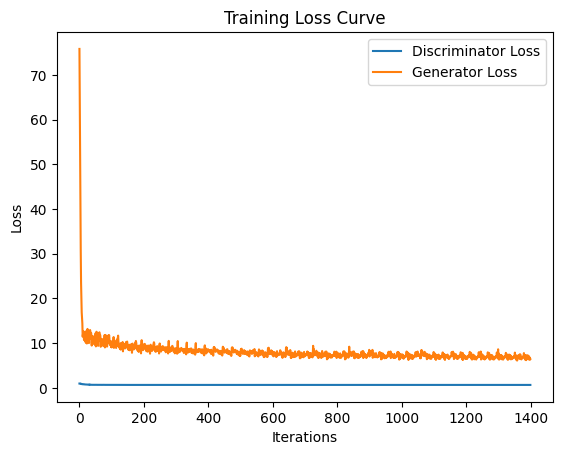

In [ ]:
#4
#lr changed to 0.0003 and batch size = 32
#num_epochs=50, batch_size=32, lr=0.0003, beta1=0.5, beta2=0.999, lambda_L1=100

generator = Generator()
discriminator = Discriminator()

use_cuda = True
if use_cuda and torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
      print('CUDA is not available.  Training on CPU ...')

train(generator, discriminator, train_loader, num_epochs=50, batch_size=1, lr=0.0002, beta1=0.5, beta2=0.999, lambda_L1=100)

In [ ]:
#5
use_cuda = True
#lambda_L1 changed to 150
#num_epochs=50, batch_size=64, lr=0.0002, beta1=0.5, beta2=0.999, lambda_L1=150
generator = Generator()
discriminator = Discriminator()

if use_cuda and torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train(generator, discriminator, train_loader, num_epochs=50, batch_size=64, lr=0.0002, beta1=0.5, beta2=0.999, lambda_L1=150)

CUDA is available!  Training on GPU ...

Epoch [1/50]


Epoch [1/50], D_loss: 0.7029, G_loss: 15.3110

Epoch [2/50]


Epoch [2/50], D_loss: 0.6830, G_loss: 14.7548

Epoch [3/50]


Epoch [3/50], D_loss: 0.6812, G_loss: 14.8139

Epoch [4/50]


Epoch [4/50], D_loss: 0.6887, G_loss: 13.9685

Epoch [5/50]


Epoch [5/50], D_loss: 0.6777, G_loss: 13.4279

Epoch [6/50]


Epoch [6/50], D_loss: 0.6770, G_loss: 14.3122

Epoch [7/50]


Epoch [7/50], D_loss: 0.6606, G_loss: 13.1510

Epoch [8/50]


Epoch [8/50], D_loss: 0.6601, G_loss: 13.7387

Epoch [9/50]


Epoch [9/50], D_loss: 0.6601, G_loss: 12.6304

Epoch [10/50]


 Saved checkpoint to /content/gdrive/MyDrive/APS36010.pth
Epoch [10/50], D_loss: 0.9770, G_loss: 13.6806

Epoch [11/50]


Epoch [11/50], D_loss: 0.8775, G_loss: 13.2451

Epoch [12/50]


Epoch [12/50], D_loss: 0.6603, G_loss: 12.1338

Epoch [13/50]


Epoch [13/50], D_loss: 0.6601, G_loss: 11.2480

Epoch [14/50]


Epoch [14/50], D_loss: 0.6601, G_loss: 10.9628

Epoch [15/50]


Epoch [15/50], D_loss: 0.6600, G_loss: 10.7624

Epoch [16/50]


Epoch [16/50], D_loss: 0.6600, G_loss: 11.0845

Epoch [17/50]


Epoch [17/50], D_loss: 0.6599, G_loss: 12.8141

Epoch [18/50]


Epoch [18/50], D_loss: 0.6600, G_loss: 11.3242

Epoch [19/50]


Epoch [19/50], D_loss: 0.6599, G_loss: 13.7321

Epoch [20/50]


 Saved checkpoint to /content/gdrive/MyDrive/APS36020.pth
Epoch [20/50], D_loss: 0.6599, G_loss: 13.5382

Epoch [21/50]


Epoch [21/50], D_loss: 0.6599, G_loss: 10.0266

Epoch [22/50]


KeyboardInterrupt: 

In [ ]:
#Qualitative Results from our Model
import matplotlib.pyplot as plt

def generate_images(model, test_input, target):
    model.eval()
    with torch.no_grad():
        prediction = model(test_input)

    plt.figure(figsize=(10, 10))
    display_list = [test_input[0], target[0], prediction[0]]
    titles = ['Input (Satellite)', 'Ground Truth (Map)', 'Predicted (Output)']

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(titles[i])
        img = display_list[i].detach().cpu().numpy()
        img = (img * 0.5) + 0.5
        img = img.transpose(1, 2, 0)
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

CUDA is available!  Training on GPU ...


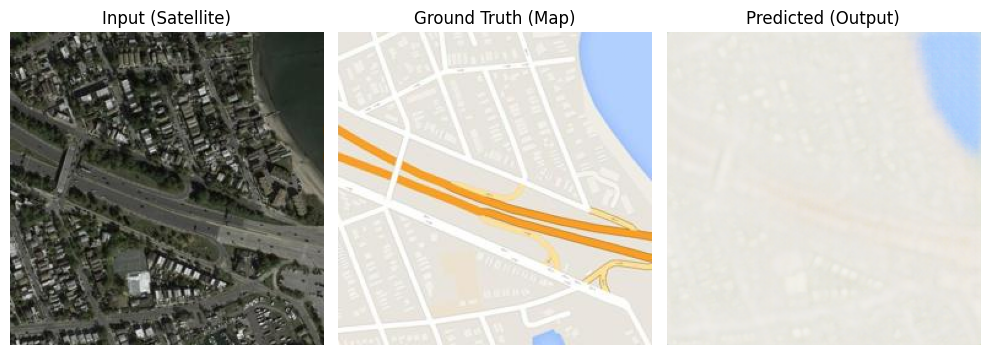

In [ ]:

if use_cuda and torch.cuda.is_available():
    generator = generator.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
      print('CUDA is not available.  Training on CPU ...')
checkpoint_path = "/content/gdrive/MyDrive/APS36040.pth"

checkpoint = torch.load(checkpoint_path, map_location='cuda')

generator.load_state_dict(checkpoint['generator'])
generator = generator.cuda()
generator.eval()

input_image, target_image = next(iter(DataLoader([val_dataset[2]], batch_size=1)))
input_image = input_image.cuda()
target_image = target_image.cuda()

generate_images(generator, input_image, target_image)

In [ ]:
import os
import shutil

mountpoint = '/content/gdrive'

# Check if the mountpoint exists and is not empty
if os.path.exists(mountpoint) and os.path.isdir(mountpoint) and os.listdir(mountpoint):
    print(f"Clearing the mountpoint: {mountpoint}")
    # Remove all contents from the mountpoint
    for item in os.listdir(mountpoint):
        item_path = os.path.join(mountpoint, item)
        try:
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
        except Exception as e:
            print(f"Error removing {item_path}: {e}")

In [ ]:
#Quantitative Result- evaluation metrics on validation data
#Using L1 Loss(Mean Absolute Error) Pixel Wise Evalaution
use_cuda = True
checkpoint_path = "/content/gdrive/MyDrive/APS36050.pth"

checkpoint = torch.load(checkpoint_path, map_location='cuda')
generator.load_state_dict(checkpoint['generator'])
generator = generator.cuda()
generator.eval()

if use_cuda and torch.cuda.is_available():
    generator = generator.cuda()
    L1_loss = nn.L1Loss().cuda()
    print('CUDA is available!  Training on GPU ...')
else:
      print('CUDA is not available.  Training on CPU ...')


total_l1_loss= 0
num_batches =0
generator.eval()
with torch.no_grad():
    for input_images, target_images in val_loader:
        input_images = input_images.cuda()
        target_images = target_images.cuda()

        fake_images = generator(input_images)
        loss = L1_loss(fake_images, target_images)
        total_l1_loss += loss.item()
        num_batches += 1
average_l1_loss = total_l1_loss / num_batches
print(f"Average L1 loss for the validation set: {average_l1_loss}")

CUDA is available!  Training on GPU ...
Average L1 loss for the validation set: 0.06910963729023933


Average L1 loss = 0.0691

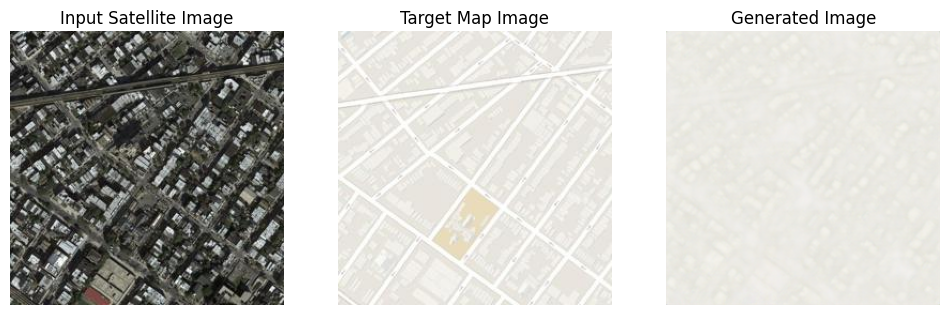

In [ ]:
import matplotlib.pyplot as plt
checkpoint_path = "/content/gdrive/MyDrive/APS36040.pth"

checkpoint = torch.load(checkpoint_path, map_location='cuda')

generator.load_state_dict(checkpoint['generator'])
generator = generator.cuda()
generator.eval()


def show_images(input_img, target_img, predicted_img):
    def denorm(t):  # [-1, 1] -> [0, 1] for viewing
        return (t + 1) / 2

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(denorm(input_img.permute(1, 2, 0)).cpu().numpy())
    plt.title("Input Satellite Map")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(denorm(target_img.permute(1, 2, 0)).cpu().numpy())
    plt.title("Target Map Image")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(denorm(predicted_img.permute(1, 2, 0)).cpu().numpy())
    plt.title("Generated Image")
    plt.axis('off')

    plt.show()

# Example: show first image from last batch
show_images(input_images[0], target_images[0], fake_images[0])

In [ ]:
#Quantitative Result- evaluation metrics on validation data
#PSNR (Peak Signal-to-Noise Ratio) Image Quality Evaluation
#Referred:https://www.cns.nyu.edu/pub/lcv/wang03-preprint.pdf
#https://www.geeksforgeeks.org/python/python-peak-signal-to-noise-ratio-psnr/
#https://www.ni.com/en/shop/data-acquisition-and-control/add-ons-for-data-acquisition-and-control/what-is-vision-development-module/peak-signal-to-noise-ratio-as-an-image-quality-metric.html?srsltid=AfmBOorLOvB-pCzPH3N6Oar62-tvFHdib1ifTRWg_HYtCi_zgs-_6ykg
#fidelity metric for evaluating pixel-level differences between generated and ground-truth images (Wang 2004)
def psnr(pred, target, max_val=2.0):
    mse = torch.mean((pred - target) ** 2)
    return 20 * torch.log10(max_val / torch.sqrt(mse))

use_cuda = True
checkpoint_path = "/content/gdrive/MyDrive/APS36040.pth"

checkpoint = torch.load(checkpoint_path, map_location='cuda')
generator.load_state_dict(checkpoint['generator'])
generator = generator.cuda()
generator.eval()

if use_cuda and torch.cuda.is_available():
    generator = generator.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
      print('CUDA is not available.  Training on CPU ...')

total_psnr = 0
num_batches = 0

with torch.no_grad():
    for input_images, target_images in val_loader:
        input_images = input_images.cuda()
        target_images = target_images.cuda()

        fake_images = generator(input_images)
        psnr_value = psnr(fake_images, target_images)
        total_psnr += psnr_value.item()
        num_batches += 1

average_psnr = total_psnr / num_batches
print(f"Average PSNR for the validation set: {average_psnr}")




CUDA is available!  Training on GPU ...
Average PSNR for the validation set: 23.508971691131592


PSNR = 23.508 dB